In [64]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from datetime import datetime, timedelta

In [35]:
raw_data = pd.read_csv("1996 to 2023 CombinedData.csv")

In [36]:
raw_data.columns

Index(['Unnamed: 0', 'name', 'datetime', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions',
       'description', 'icon', 'stations'],
      dtype='object')

In [37]:
def plotSeasonality(df, col):
    fig, ax = plt.subplots(2, 2, figsize = (14, 14))

    df.boxplot(column = [col], by = "Month", ax = ax[0, 0])
    ax[0, 1].scatter(df["Month"], df[col])
    
    
    df.boxplot(column = [col], by = "Year", ax = ax[1, 0])
    ax[1, 1].scatter(df["Year"], df[col])

    
    ax[0, 0].set_title("Month - Box Plot")
    ax[0, 1].set_title("Month - Scatter Plot")
    ax[1, 0].set_title("Year - Box Plot")
    ax[1, 1].set_title("Year - Scatter Plot")
    
    plt.show()
    

# Check Monthly Seasonality

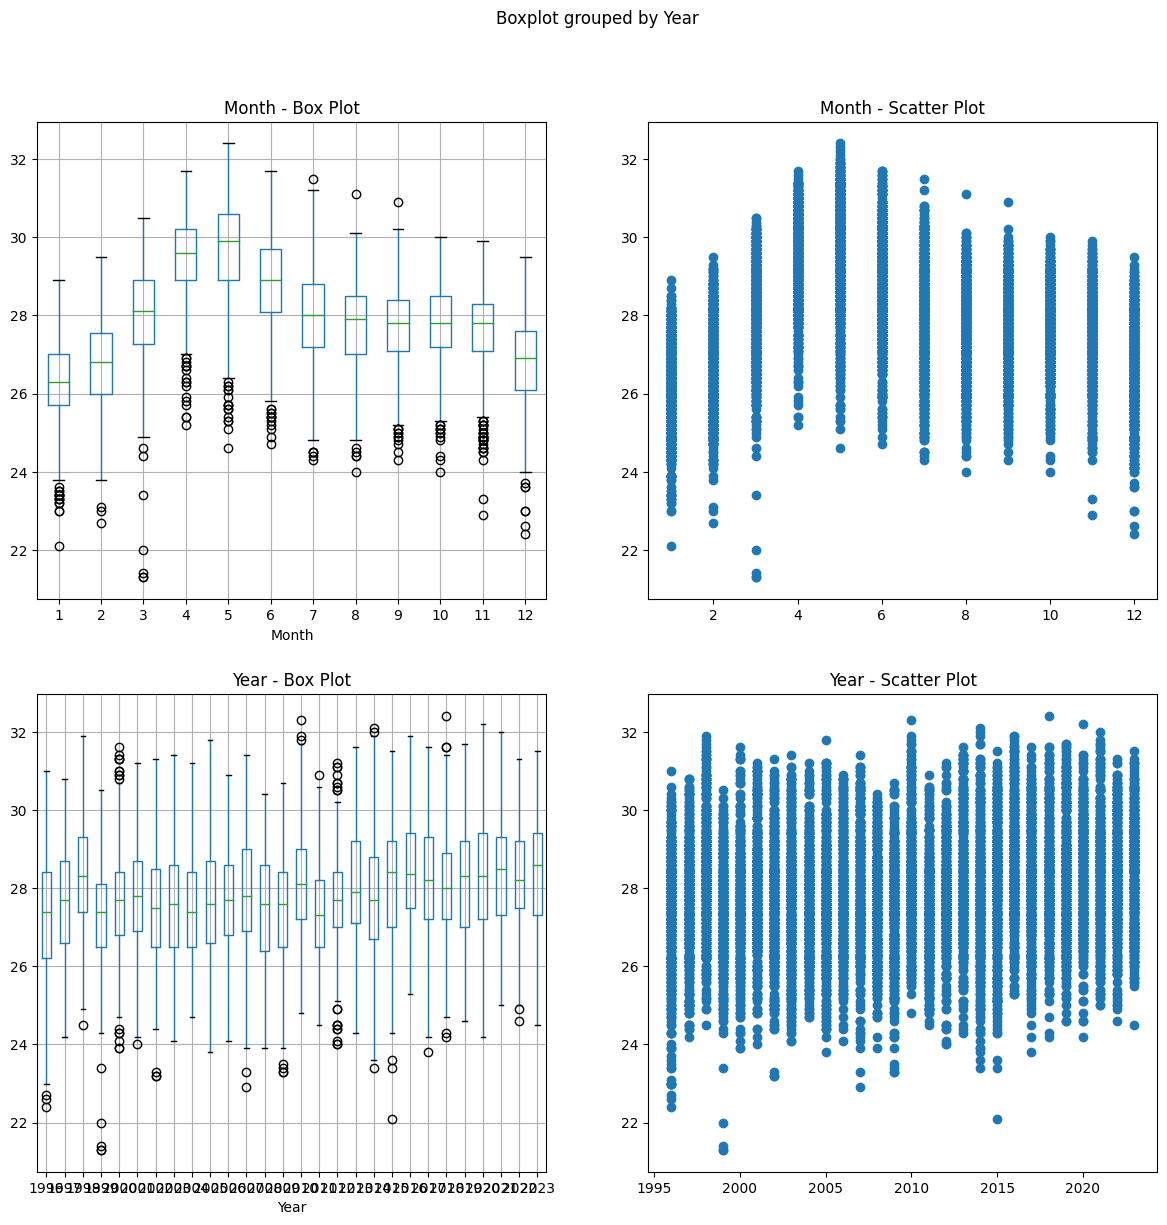

In [38]:
df = raw_data.copy()
df["Month"] = pd.DatetimeIndex(df["datetime"]).month
df["Year"] = pd.DatetimeIndex(df["datetime"]).year

plotSeasonality(df, "temp")


# Remove Monthly Mean

Since there is no seasonality (Or is there) found on the yearly data, but strong seasonality observed in Monthly Data

In [39]:
normalized_df = df.copy()
normalized_df["TempMod"] = normalized_df["temp"]

month_grp = normalized_df.groupby(by = "Month").mean(numeric_only = True)["temp"]

# For Every Month in the list of unique Months in the Dataframe
for month in normalized_df['Month'].unique():
    # Look for df["Month"] == current unique month, Change TempMod Value to be (currentTemp of the Day) - (Monthly Mean)
    normalized_df.loc[normalized_df['Month'] == month, 'TempMod'] -= month_grp[month]

# Get The Mean of the Normalized Month Groups
monthly_mean = normalized_df['TempMod'].mean()
print("Current Monthly Mean:", monthly_mean)

# Subtract the Normalized Temperature Mean by the Total Mean of all the other Normalized
normalized_df['TempMod'] = normalized_df['TempMod'] - monthly_mean
current_monthly_mean = normalized_df["TempMod"].mean()


Current Monthly Mean: -2.6679222697944507e-16


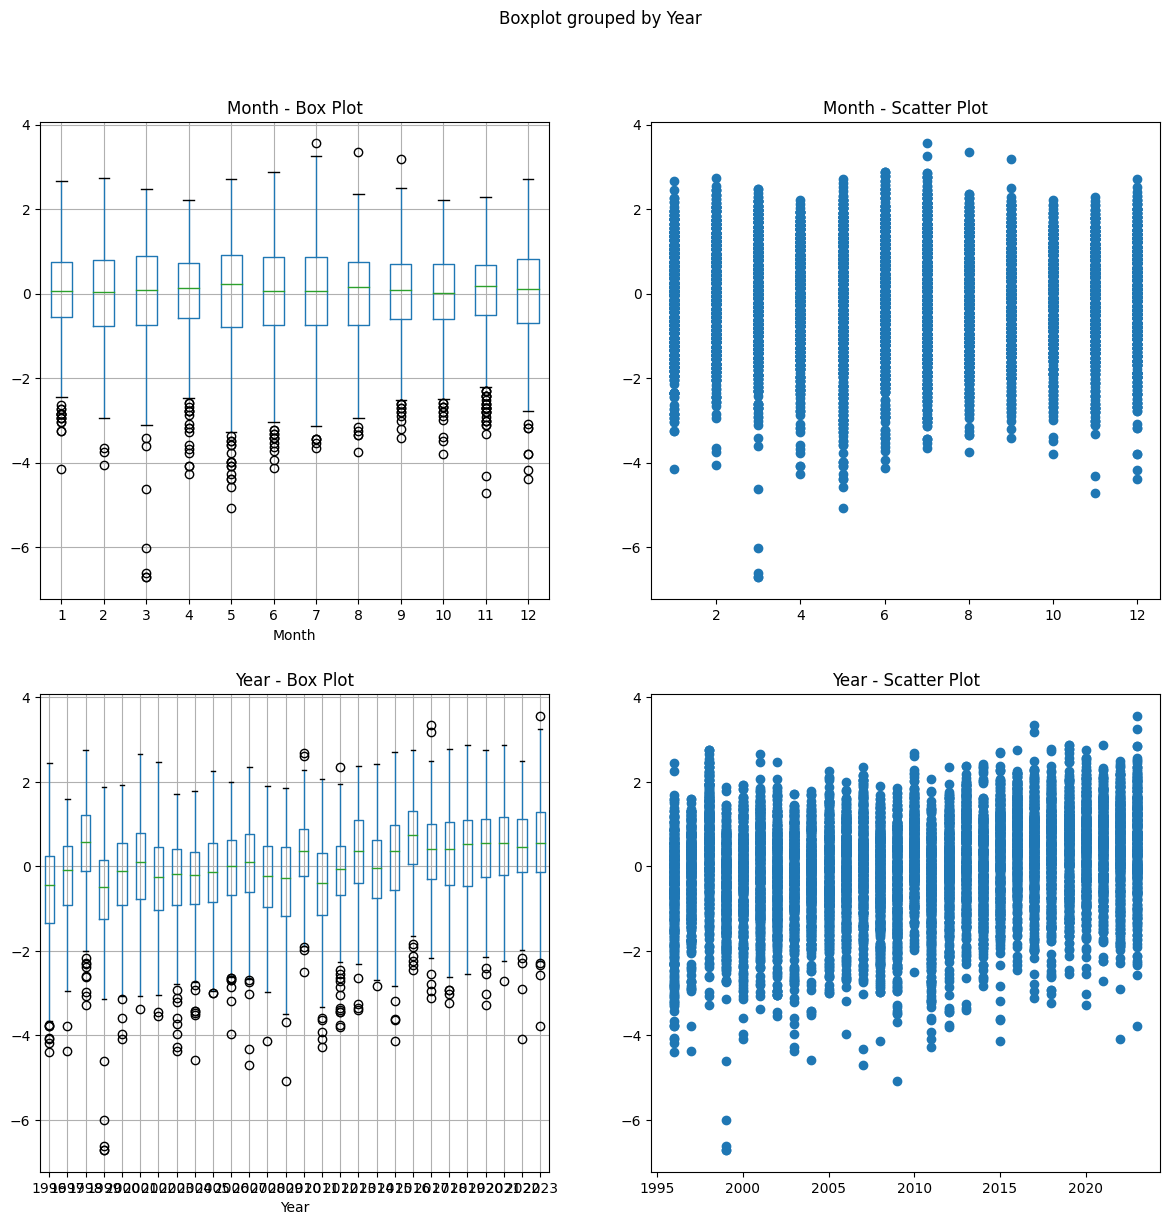

In [40]:
plotSeasonality(normalized_df, "TempMod")

In [41]:
normalized_df["TempMod"]

0       -2.842857
1       -1.942857
2       -2.742857
3       -3.242857
4       -3.242857
           ...   
10222    0.613479
10223    1.013479
10224    0.913479
10225    1.213479
10226    1.613479
Name: TempMod, Length: 10227, dtype: float64

In [42]:
MODEL_ORDER = 2
MODEL_PREDICTOR = LinearRegression()
MODEL_SIGMA = None 

In [43]:
def window_data(data):
    n = len(data)
    x = []
    y = []
    for i in range(n - MODEL_ORDER):
        x.append(data[i : i + MODEL_ORDER])
        y.append(data[i + MODEL_ORDER])
    
    return np.array(x), np.array(y)

In [44]:
train_data = normalized_df["TempMod"].to_numpy()
n = len(train_data)
split_point = int(0.7 * n)

MODEL_SIGMA = np.std(train_data[:split_point])
window_x, window_y = window_data(train_data)

train_x = window_x[:split_point]
test_x = window_x[split_point:]
train_y = window_y[:split_point]
test_y = window_y[split_point:]

In [45]:
MODEL_PREDICTOR.fit(train_x, train_y)

LinearRegression()

In [146]:
test_len = len(test_x)
preds = np.array([])

# This should have the values of the last X 
r_queue = np.copy(train_x)[-MODEL_ORDER]

# num_predictions = test_len
num_predictions = 50 * 365

for i in tqdm(range(num_predictions)):

    # Reshape and do not apply on rolling queue 
    tr = np.reshape(r_queue, (1, -1))
    resid = np.random.normal(loc = 0, scale = MODEL_SIGMA)
    # resid = 0
    next_val = MODEL_PREDICTOR.predict(tr) + resid 

    preds = np.append(preds, next_val)

    r_queue = np.roll(r_queue, -1)
    r_queue[-1] = next_val



100%|██████████| 18250/18250 [00:02<00:00, 6499.64it/s]


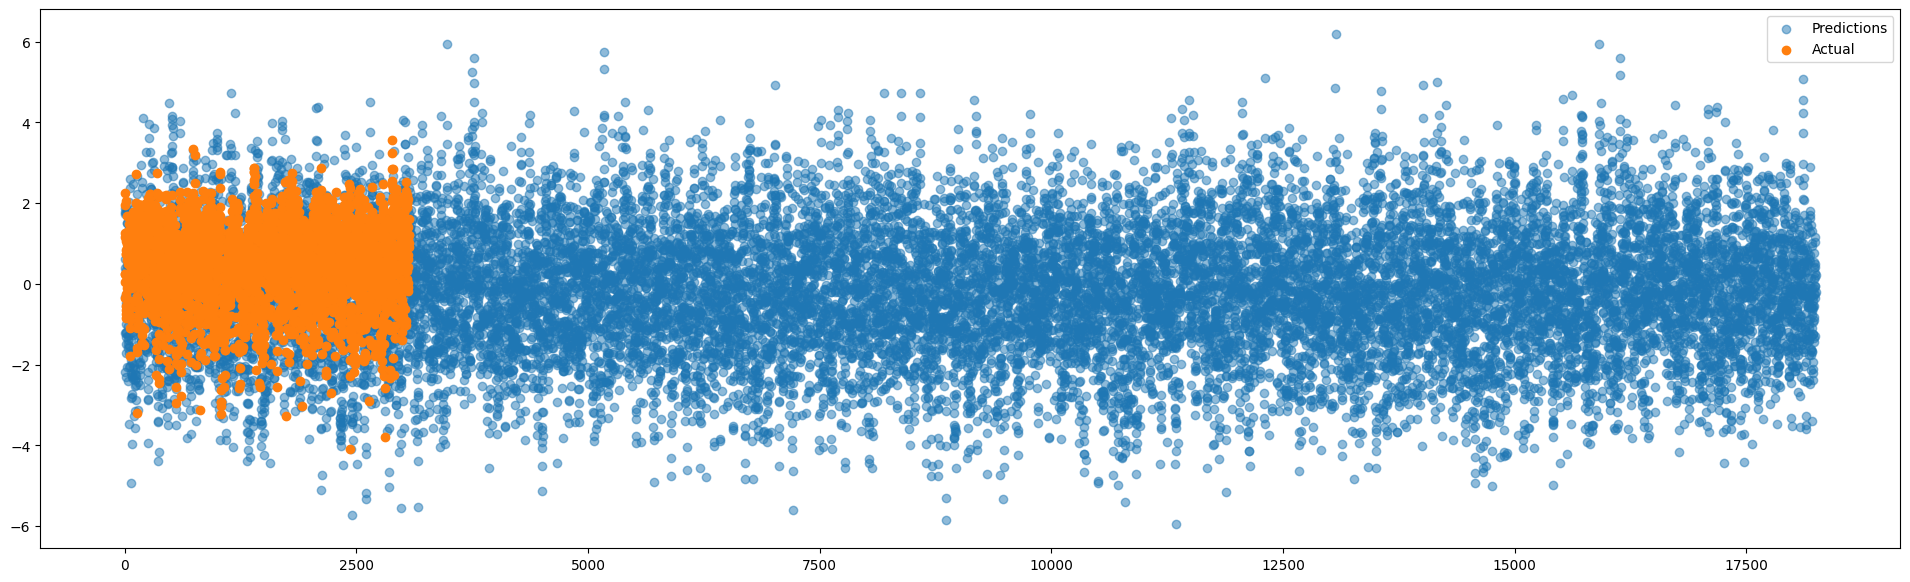

In [147]:
plt.figure(figsize=(24, 7))
plt.scatter(np.arange(0, len(preds)), preds, alpha = 0.5, label = "Predictions")
plt.scatter(np.arange(0, len(test_y)), test_y, label = "Actual")
plt.legend()
plt.show()

In [148]:
pred_df = normalized_df[["datetime", "TempMod"]]
pred_df

,datetime,TempMod
0,1996-01-01,-2.842857
1,1996-01-02,-1.942857
2,1996-01-03,-2.742857
3,1996-01-04,-3.242857
4,1996-01-05,-3.242857
...,...,...
10222,2023-12-27,0.613479
10223,2023-12-28,1.013479
10224,2023-12-29,0.913479
10225,2023-12-30,1.213479


In [149]:
preds.shape, train_y.shape, preds.shape[0] + train_y.shape[0] + MODEL_ORDER

((18250,), (7158,), 25410)

In [150]:
normalized_df["TempMod"][MODEL_ORDER], train_y[0]

(-2.7428571428571433, -2.7428571428571433)

In [151]:
normalized_df[["datetime", "TempMod"]][2:]

,datetime,TempMod
2,1996-01-03,-2.742857
3,1996-01-04,-3.242857
4,1996-01-05,-3.242857
5,1996-01-06,-1.342857
6,1996-01-07,-1.442857
...,...,...
10222,2023-12-27,0.613479
10223,2023-12-28,1.013479
10224,2023-12-29,0.913479
10225,2023-12-30,1.213479


In [152]:
train_y[0], train_y[-1]

(-2.7428571428571433, 1.4519585253456209)

In [153]:
normalized_df[["datetime", "TempMod"]].loc[MODEL_ORDER, ]

datetime    1996-01-03
TempMod      -2.742857
Name: 2, dtype: object

In [154]:
normalized_df[["datetime", "TempMod"]].loc[len(train_y) + MODEL_ORDER - 1, ]

datetime    2015-08-08
TempMod       1.451959
Name: 7159, dtype: object

In [188]:
StringFormat = "%Y-%M-%d"
raw_start_date = normalized_df["datetime"][MODEL_ORDER]
start_date = datetime.strptime(raw_start_date, StringFormat)
end_date = start_date + timedelta(days = len(train_y)) # + 1 Since Range <
test_start_date = end_date + timedelta(days = 1)
test_end_date = test_start_date + timedelta(days = len(preds)) # + 1 Since Range <

In [189]:
len(preds), len(preds) + len(train_y)

(18250, 25408)

In [166]:
start_date + timedelta(days = len(train_y) - 1), start_date

(datetime.datetime(2015, 8, 8, 0, 1), datetime.datetime(1996, 1, 3, 0, 1))

In [167]:
test_end_date

datetime.datetime(2045, 12, 22, 0, 1)

In [190]:
training_date_range = np.arange(start_date, end_date, timedelta(days = 1)).astype("datetime64[D]")
testing_date_range = np.arange(test_start_date, test_end_date, timedelta(days = 1)).astype("datetime64[D]")


In [192]:
training_date_range.shape, train_y.shape, testing_date_range.shape, preds.shape

((7158,), (7158,), (18250,), (18250,))

In [194]:
full_datetime_range = np.concatenate((training_date_range, testing_date_range))
full_datetime_range.shape

(25408,)

In [195]:
full_datetime_range

array(['1996-01-03', '1996-01-04', '1996-01-05', ..., '2065-07-25',
       '2065-07-26', '2065-07-27'], dtype='datetime64[D]')

In [196]:
preds.shape

(18250,)

In [197]:
concatenated_preds = np.concatenate((train_y, preds))

In [198]:
concatenated_preds.shape, full_datetime_range.shape, (concatenated_preds.shape[0] - full_datetime_range.shape[0]) / 365

((25408,), (25408,), 0.0)

In [199]:
constructed_df = pd.DataFrame({
    "datetime" : full_datetime_range,
    "temp" : concatenated_preds
})

In [200]:
constructed_df

,datetime,temp
0,1996-01-03,-2.742857
1,1996-01-04,-3.242857
2,1996-01-05,-3.242857
3,1996-01-06,-1.342857
4,1996-01-07,-1.442857
...,...,...
25403,2065-07-23,0.283684
25404,2065-07-24,-0.260050
25405,2065-07-25,0.419570
25406,2065-07-26,0.214993


In [202]:
orig_vals = normalized_df[["datetime", "TempMod"]]["TempMod"][2:].values
cons_val = constructed_df["temp"].values
diffs = np.absolute(orig_vals - cons_val)


ValueError: operands could not be broadcast together with shapes (10225,) (25408,) 

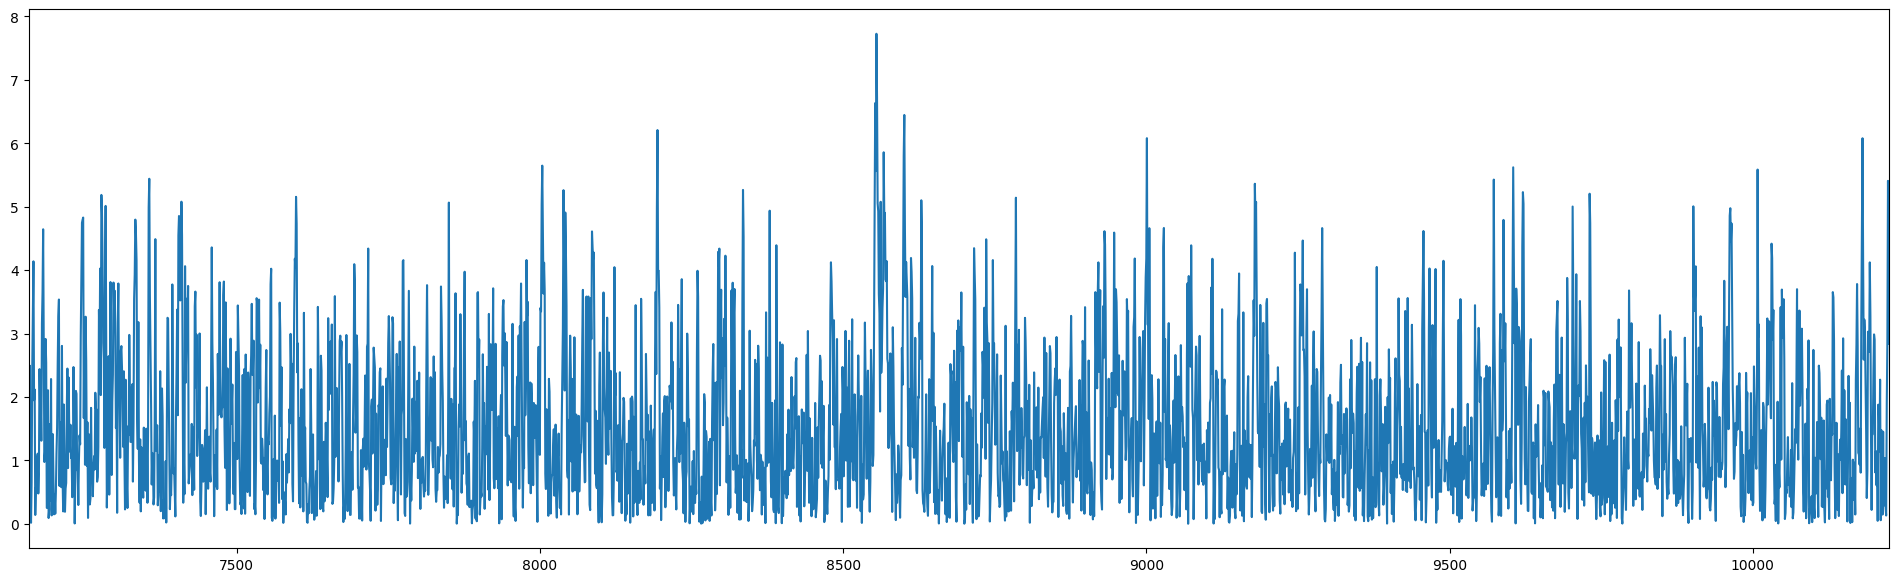

In [ ]:
plt.figure(figsize=(24, 7))
plt.plot(diffs)
plt.xlim(len(cons_val) - len(test_y) - 1, len(cons_val) - 1)
plt.show()

In [ ]:
# Reconstruct the Dates
# From Training X Add the dates
# Continue Dates until after Training X
# Add the Monthly Mean to Dataframe

In [203]:
constructed_df["Month"] = pd.DatetimeIndex(constructed_df["datetime"]).month

In [204]:
constructed_df["TempMod"] = constructed_df["temp"]

for month in constructed_df["Month"].unique():
    constructed_df.loc[constructed_df['Month'] == month, 'TempMod'] += month_grp[month]

constructed_df["TempMod"] += monthly_mean

<Axes: >

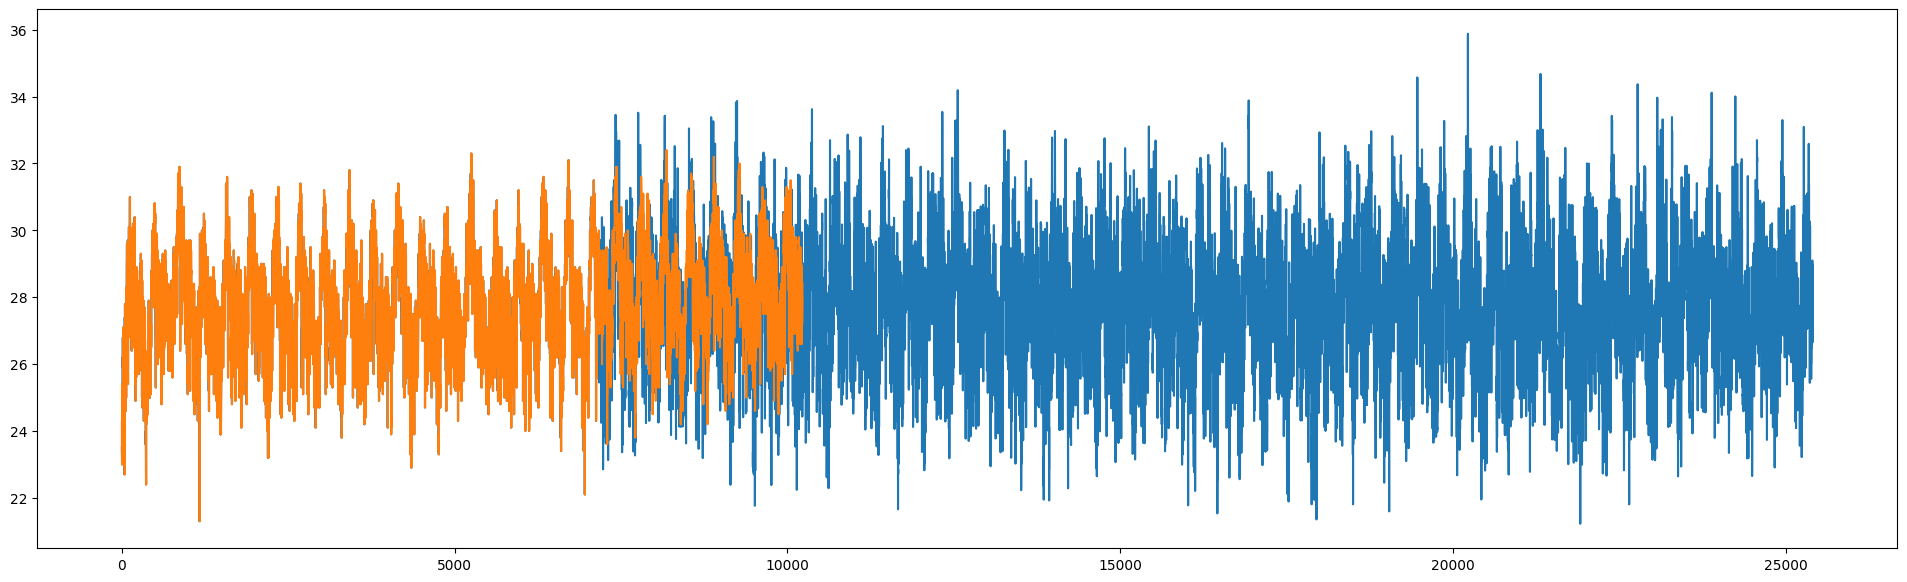

In [205]:
constructed_df["TempMod"].plot(figsize = (24, 7))
normalized_df["temp"].plot(figsize = (24, 7))

In [207]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [234]:
dec

,datetime,temp,Month,TempMod
datetime,,,,
1996-01-03,1996-01-03,-2.742857,1,23.500000
1996-01-04,1996-01-04,-3.242857,1,23.000000
1996-01-05,1996-01-05,-3.242857,1,23.000000
1996-01-06,1996-01-06,-1.342857,1,24.900000
1996-01-07,1996-01-07,-1.442857,1,24.800000
...,...,...,...,...
2065-07-23,2065-07-23,0.283684,7,28.229306
2065-07-24,2065-07-24,-0.260050,7,27.685572
2065-07-25,2065-07-25,0.419570,7,28.365192


In [242]:
dec

,datetime,temp,Month,TempMod
datetime,,,,
1996-01-03,1996-01-03,23.500000,1,23.500000
1996-01-04,1996-01-04,23.000000,1,23.000000
1996-01-05,1996-01-05,23.000000,1,23.000000
1996-01-06,1996-01-06,24.900000,1,24.900000
1996-01-07,1996-01-07,24.800000,1,24.800000
...,...,...,...,...
2065-07-23,2065-07-23,28.229306,7,28.229306
2065-07-24,2065-07-24,27.685572,7,27.685572
2065-07-25,2065-07-25,28.365192,7,28.365192


In [243]:
dec.index.unique()

DatetimeIndex(['1996-01-03', '1996-01-04', '1996-01-05', '1996-01-06',
               '1996-01-07', '1996-01-08', '1996-01-09', '1996-01-10',
               '1996-01-11', '1996-01-12',
               ...
               '2065-07-18', '2065-07-19', '2065-07-20', '2065-07-21',
               '2065-07-22', '2065-07-23', '2065-07-24', '2065-07-25',
               '2065-07-26', '2065-07-27'],
              dtype='datetime64[s]', name='datetime', length=25408, freq=None)

In [248]:
dec.index.unique()

DatetimeIndex(['1996-01-01', '1996-01-02', '1996-01-03', '1996-01-04',
               '1996-01-05', '1996-01-06', '1996-01-07', '1996-01-08',
               '1996-01-09', '1996-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='datetime', length=10227, freq=None)

In [270]:
# dec = constructed_df.copy()
# dec = df.copy()
dec.index = pd.DatetimeIndex(dec["datetime"])
dec["temp"] = dec["TempMod"]

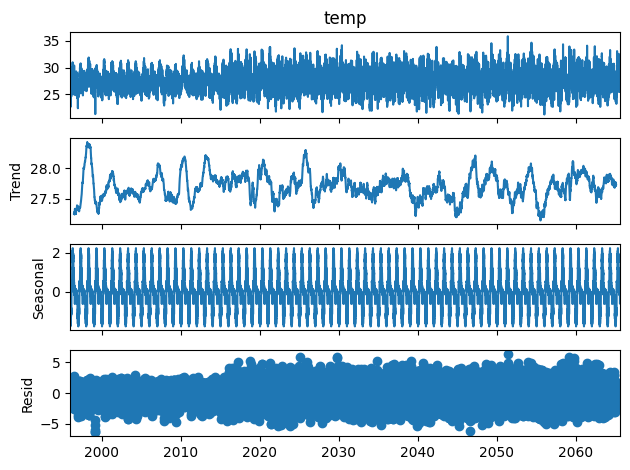

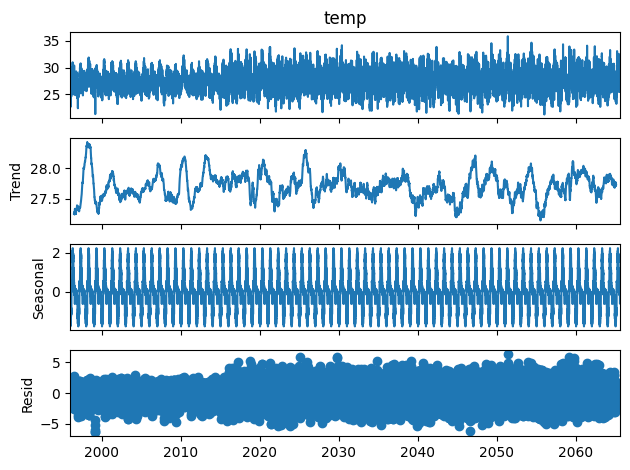

In [271]:

dec_result = seasonal_decompose(dec["temp"], model = "additive", period = 365)
# dec_result = seasonal_decompose(dec["temp"].copy(), model = "multiplicative")
dec_result.plot()


<Axes: xlabel='datetime'>

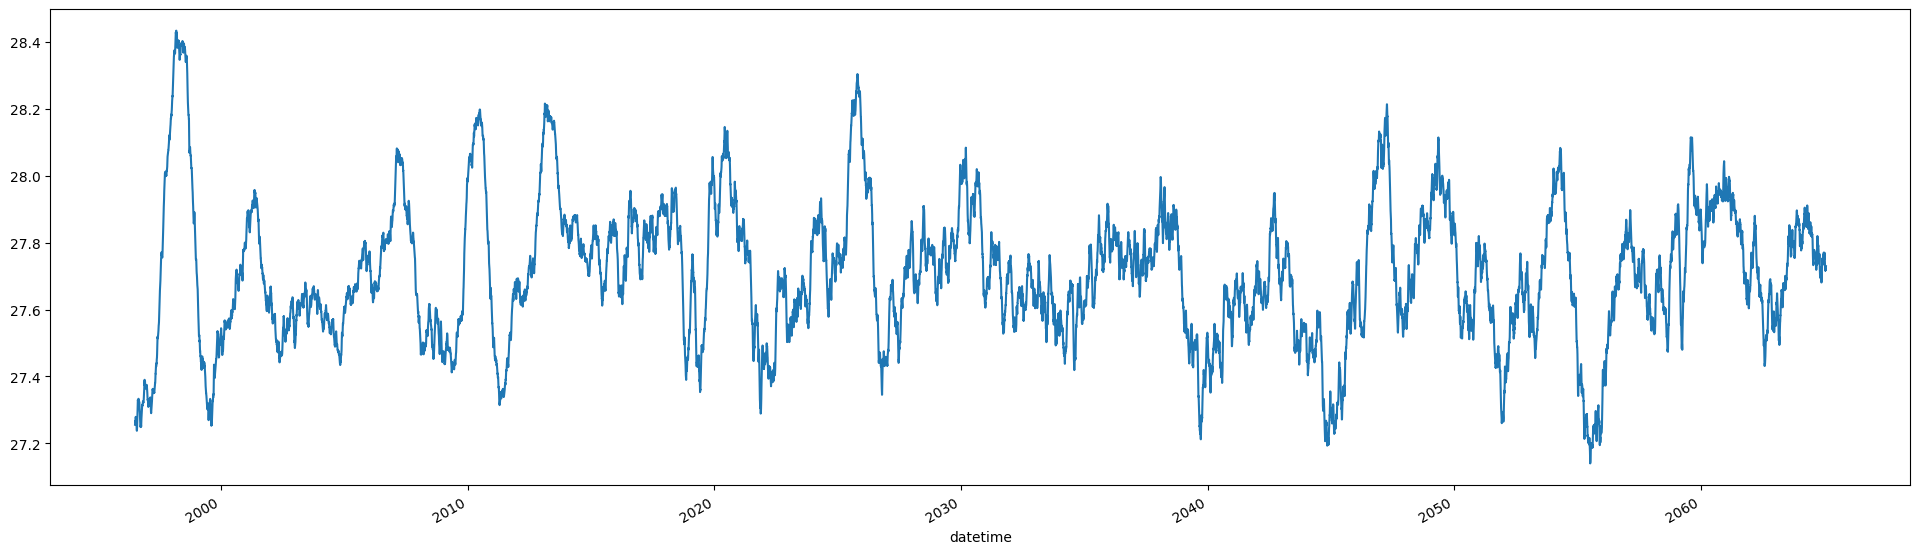

In [272]:
dec_result.trend.plot(figsize = (24, 7))

<Axes: xlabel='datetime'>

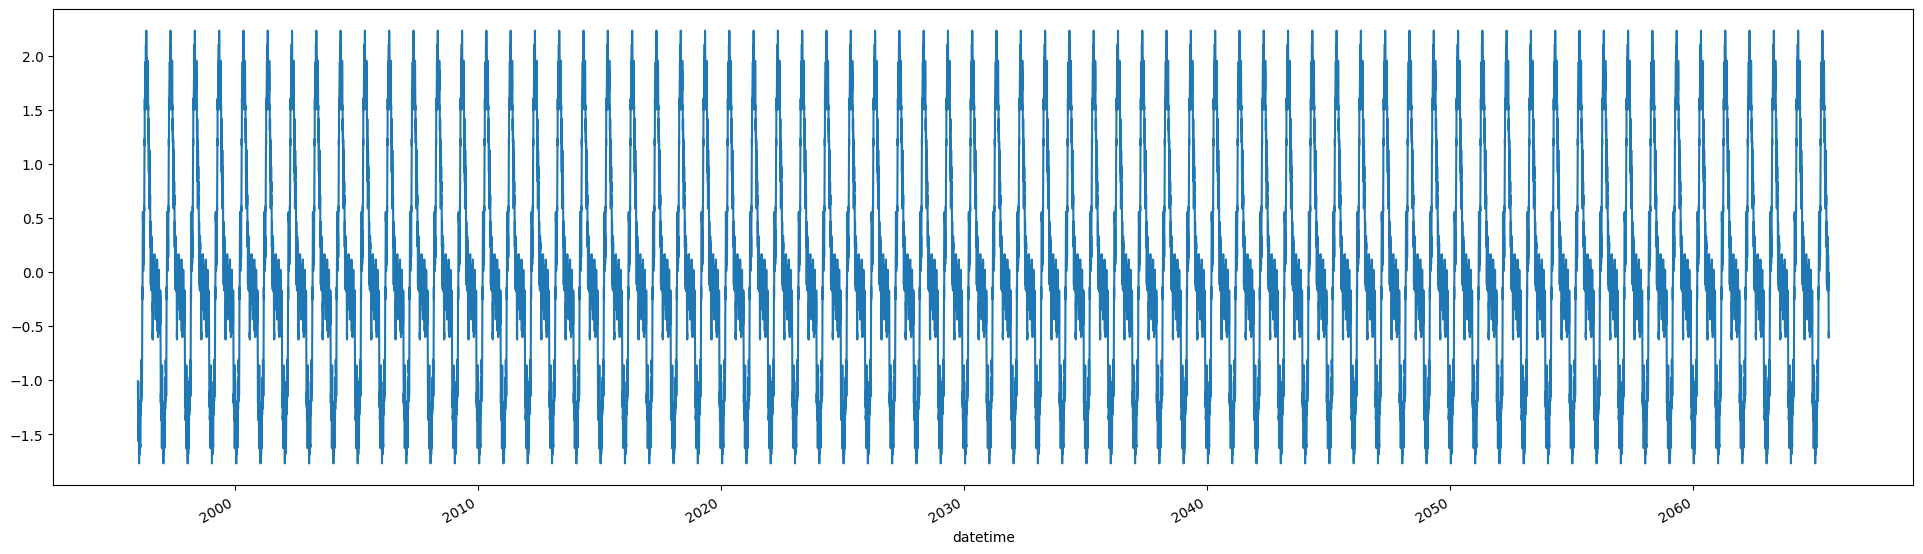

In [273]:
dec_result.seasonal.plot(figsize = (24, 7))

<Axes: xlabel='datetime'>

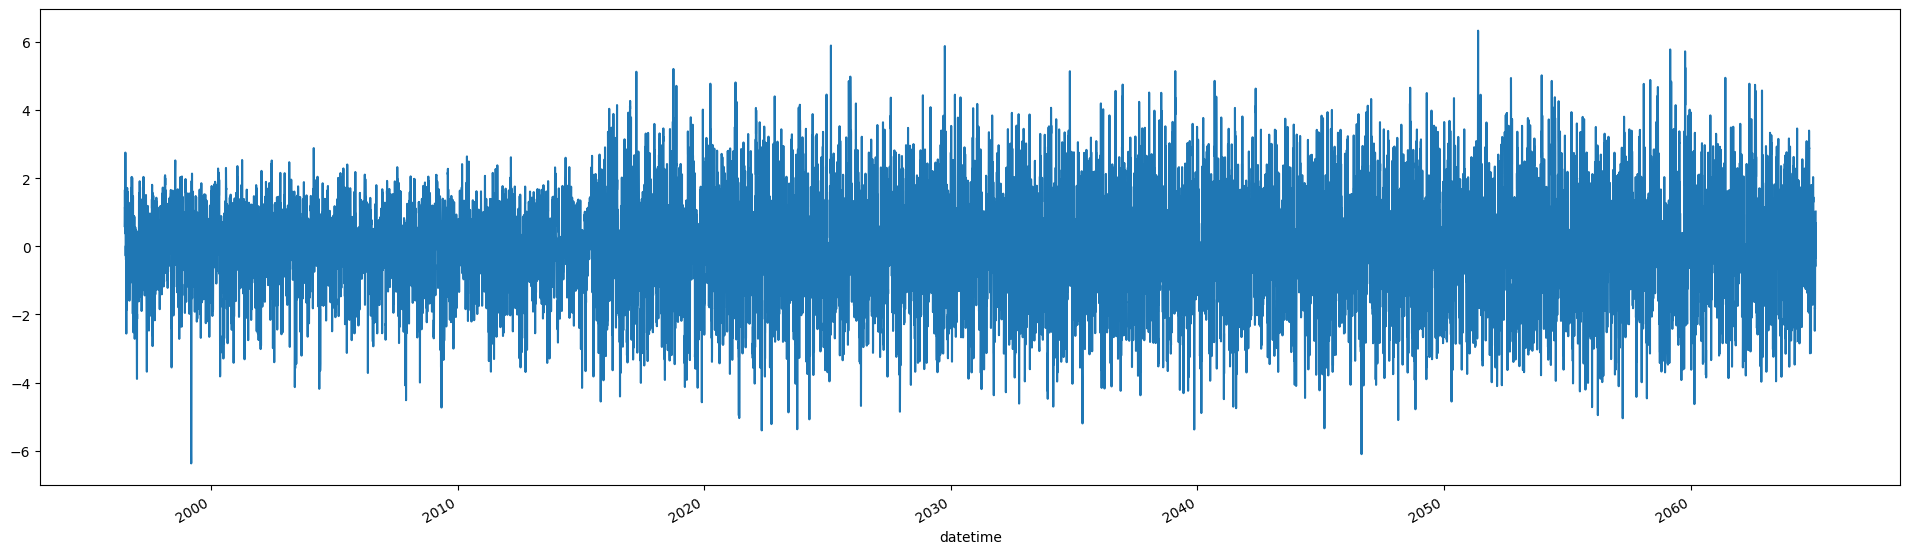

In [274]:
dec_result.resid.plot(figsize = (24, 7))

In [277]:
dec_result.trend.dropna()

datetime
1996-07-03    27.255890
1996-07-04    27.257808
1996-07-05    27.262740
1996-07-06    27.266575
1996-07-07    27.266575
                ...    
2065-01-22    27.721201
2065-01-23    27.722033
2065-01-24    27.726652
2065-01-25    27.728577
2065-01-26    27.729588
Name: trend, Length: 25044, dtype: float64

In [278]:
trend_examine = dec_result.trend.dropna()

In [281]:
sd = seasonal_decompose(trend_examine, model = "additive", period = 365)

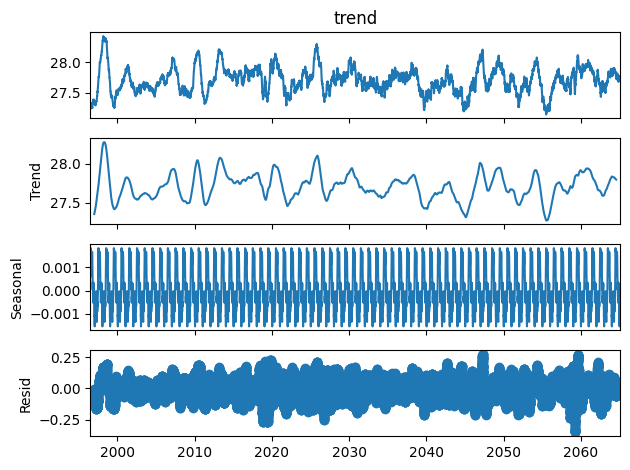

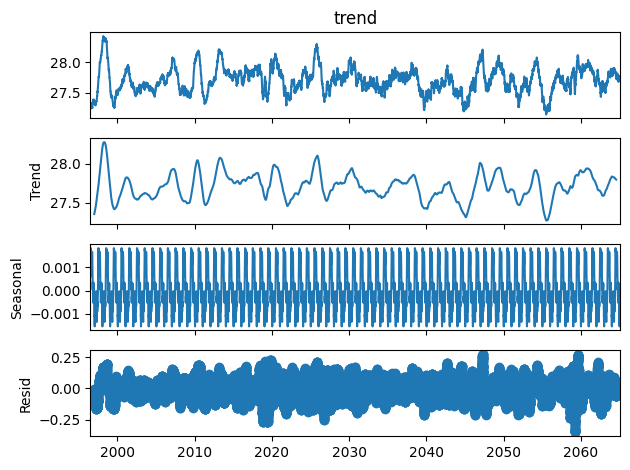

In [282]:
sd.plot()